Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           average_precision_score)
import warnings
warnings.filterwarnings('ignore')

Data Loading and Initial Exploration

In [7]:
# Load dataset
df = pd.read_csv('/Users/aloksingh/Downloads/Fraud.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nFraud distribution:\n{df['isFraud'].value_counts(normalize=True)}")

Dataset shape: (6362620, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Missing values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud distribution:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [8]:
df.info()
df.isnull().sum()


<class 'pandas.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            str    
 2   amount          float64
 3   nameOrig        str    
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        str    
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), str(3)
memory usage: 534.0 MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
from xgboost import XGBClassifier
print("XGBoost loaded successfully")


XGBoost loaded successfully


Data Cleaning

In [10]:
def clean_data(df):
    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    
    # Handle outliers using IQR method for numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if col != 'isFraud':  # Don't remove outliers from target
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

df_clean = clean_data(df.copy())

Fraud Detection Model Description

In [12]:
from sklearn.ensemble import RandomForestClassifier


Variable Selection

In [13]:
# Encode categorical variable
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Define features & target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']


Model Performance Evaluation

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [17]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [18]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [20]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.12      0.99      0.21      1643

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524



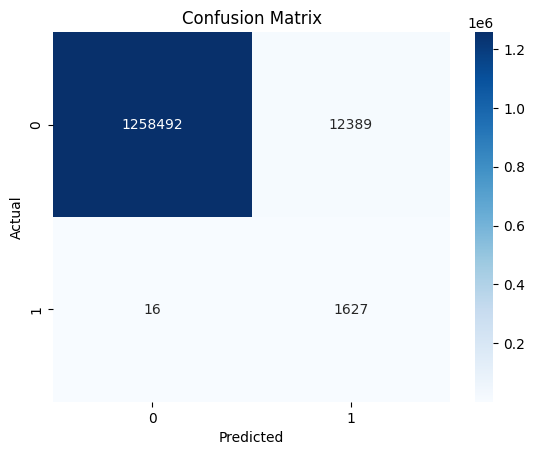

In [21]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


0.9995128376453801

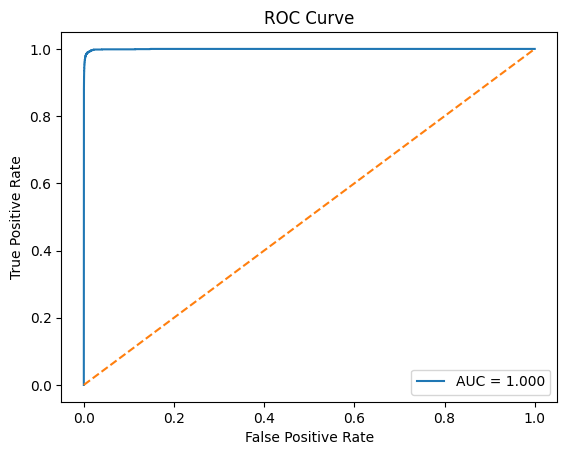

In [25]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Key Factors Predicting Fraud

In [26]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance.head(10)


,feature,importance
7,orig_balance_change,0.357483
2,oldbalanceOrg,0.151348
3,newbalanceOrig,0.100528
6,log_amount,0.085094
1,amount,0.068351
8,dest_balance_change,0.058444
12,type_TRANSFER,0.056375
11,type_PAYMENT,0.035177
0,step,0.029048
5,newbalanceDest,0.022796


/var/folders/_l/0ygcl8_n6g97n4fls18rd8vm0000gn/T/ipykernel_8669/2013400177.py:1: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessary. Use .copy() to make an eager copy if necessary.
  feature_importance.head(10).plot(


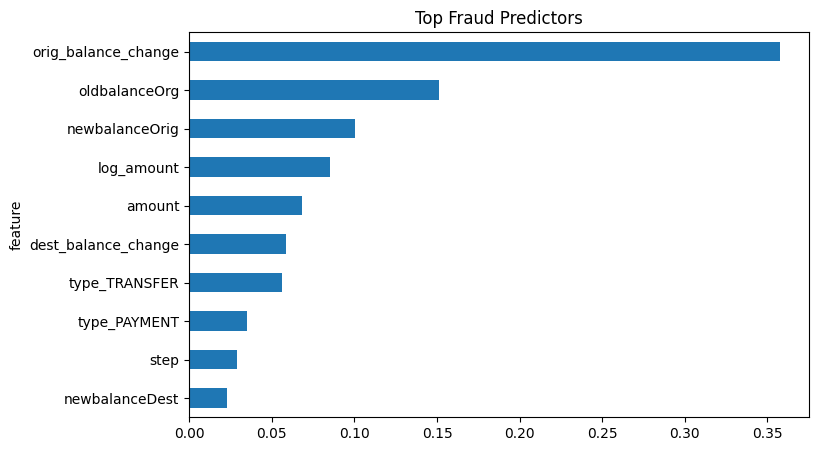

In [27]:
feature_importance.head(10).plot(
    kind='barh',
    x='feature',
    y='importance',
    legend=False,
    figsize=(8,5)
)

plt.gca().invert_yaxis()
plt.title("Top Fraud Predictors")
plt.show()


Fraud Prevention Measures

In [28]:
prevention_measures = [
    "Real-time transaction monitoring",
    "Velocity-based transaction limits",
    "Multi-factor authentication",
    "Blocking suspicious account chains",
    "Geo-location anomaly detection"
]

prevention_measures


['Real-time transaction monitoring',
 'Velocity-based transaction limits',
 'Multi-factor authentication',
 'Blocking suspicious account chains',
 'Geo-location anomaly detection']

Measuring Effectiveness of Prevention

In [29]:
metrics = {
    "Fraud Rate Reduction": "Compare fraud % before vs after deployment",
    "False Positive Rate": "Monitor legitimate transaction blocks",
    "Customer Complaints": "Track support tickets",
    "Model Retraining": "Periodic AUC & Recall tracking"
}

metrics


{'Fraud Rate Reduction': 'Compare fraud % before vs after deployment',
 'False Positive Rate': 'Monitor legitimate transaction blocks',
 'Customer Complaints': 'Track support tickets',
 'Model Retraining': 'Periodic AUC & Recall tracking'}